#Regression and Regularization

Using regularization - Lasso and Ridge

Will go through 2 examples, one for linear regression and one for Logistic Regression (classification).

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
%matplotlib inline



## Input and EDA: Ames Housing Data

We are going to use the Housing data colleced from Ames, Iowa.  This data has features on homes for sale and their selling price, we want to see if we can build a model to estimate sales price, which will be useful for looking for over or under-valued homes.  Data can be [downloaded from this link](https://drive.google.com/uc?export=download&id=1fq_hzpV0DbXAOqOZFndIKq-bsEO6JG9r).  More info about the data from the [Kaggle page](https://www.kaggle.com/datasets/shashanknecrothapa/ames-housing-dataset).

The data set has a lot of features!!! For simplicity, I have selected a subset that are most interesting for this exercise, but feel free to explore others and see how good your model can get.

In [2]:
# Input Ames data

df = pd.read_csv('AmesHousing.csv')

# take a look at the features and select the ones that we want to use
# df.columns

my_features = ['Lot Area','Year Built','Bldg Type', 'House Style','1st Flr SF','2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Bedroom AbvGr', 'Garage Area', 'Gr Liv Area',
       'Overall Qual','BsmtFin Type 1', 'BsmtFin SF 1','Heating', 'Heating QC',
       'Overall Cond','SalePrice']

Ames = df[my_features].copy()


# a little bit of feature engineering...creating a Total SqFt from 1st and 2nd
Ames['TotSqFt']=Ames['1st Flr SF']+Ames['2nd Flr SF']+Ames['BsmtFin SF 1']

# indicator for does it have a second floor?
Ames['Second']=np.where(Ames['2nd Flr SF']>0,1,0)
Ames.drop(['1st Flr SF','2nd Flr SF'],axis=1,inplace=True)

Ames.head()


,Lot Area,Year Built,Bldg Type,House Style,Full Bath,TotRms AbvGrd,Bedroom AbvGr,Garage Area,Gr Liv Area,Overall Qual,BsmtFin Type 1,BsmtFin SF 1,Heating,Heating QC,Overall Cond,SalePrice,TotSqFt,Second
0,31770,1960,1Fam,1Story,1,7,3,528.0,1656,6,BLQ,639.0,GasA,Fa,5,215000,2295.0,0
1,11622,1961,1Fam,1Story,1,5,2,730.0,896,5,Rec,468.0,GasA,TA,6,105000,1364.0,0
2,14267,1958,1Fam,1Story,1,6,3,312.0,1329,6,ALQ,923.0,GasA,TA,6,172000,2252.0,0
3,11160,1968,1Fam,1Story,2,8,3,522.0,2110,7,ALQ,1065.0,GasA,Ex,5,244000,3175.0,0
4,13830,1997,1Fam,2Story,2,6,3,482.0,1629,5,GLQ,791.0,GasA,Gd,5,189900,2420.0,1


In [3]:
Ames.describe()

,Lot Area,Year Built,Full Bath,TotRms AbvGrd,Bedroom AbvGr,Garage Area,Gr Liv Area,Overall Qual,BsmtFin SF 1,Overall Cond,SalePrice,TotSqFt,Second
count,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2929.000000,2930.000000,2930.000000,2929.000000,2930.000000,2930.000000,2929.00000,2930.000000
mean,10147.921843,1971.356314,1.566553,6.443003,2.854266,472.819734,1499.690444,6.094881,442.629566,5.563140,180796.060068,1937.84773,0.427304
std,7880.017759,30.245361,0.552941,1.572964,0.827731,215.046549,505.508887,1.411026,455.590839,1.111537,79886.692357,748.33929,0.494771
min,1300.000000,1872.000000,0.000000,2.000000,0.000000,0.000000,334.000000,1.000000,0.000000,1.000000,12789.000000,334.00000,0.000000
25%,7440.250000,1954.000000,1.000000,5.000000,2.000000,320.000000,1126.000000,5.000000,0.000000,5.000000,129500.000000,1446.00000,0.000000
50%,9436.500000,1973.000000,2.000000,6.000000,3.000000,480.000000,1442.000000,6.000000,370.000000,5.000000,160000.000000,1797.00000,0.000000
75%,11555.250000,2001.000000,2.000000,7.000000,3.000000,576.000000,1742.750000,7.000000,734.000000,6.000000,213500.000000,2301.00000,1.000000
max,215245.000000,2010.000000,4.000000,15.000000,8.000000,1488.000000,5642.000000,10.000000,5644.000000,9.000000,755000.000000,11286.00000,1.000000


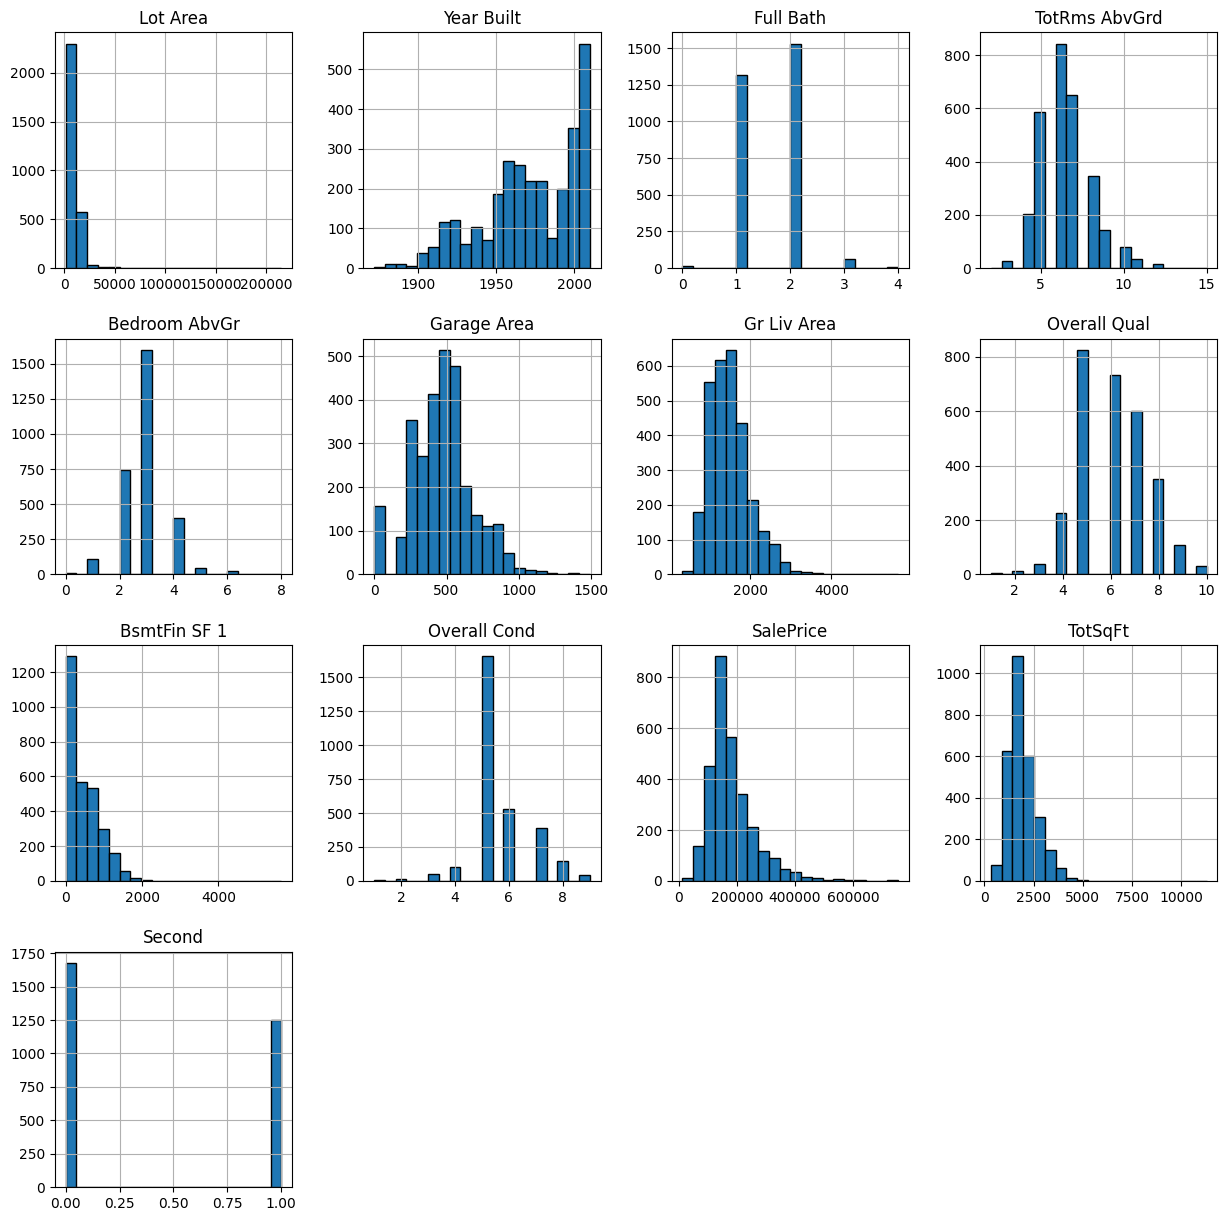

In [4]:
Ames.hist(figsize=(15,15),edgecolor='black',bins=20)
plt.show()

In [5]:
# replace Lot Area with a log version
Ames['Lot Area']=np.log(Ames['Lot Area'])
Ames['TotSqFt']=np.log(Ames['TotSqFt'])


Check for and deal with NAs...

In [6]:
# count missing values
Ames.isna().sum()

,0
Lot Area,0
Year Built,0
Bldg Type,0
House Style,0
Full Bath,0
TotRms AbvGrd,0
Bedroom AbvGr,0
Garage Area,1
Gr Liv Area,0
Overall Qual,0


In [7]:
# fill in NAs for BsmtMin Type1 with null, and remove others
Ames['BsmtFin Type 1'] = Ames['BsmtFin Type 1'].fillna('None')
Ames = Ames.dropna()

Because we are doing regression, we need to `get_dummies` for the categoricals (make sure to use `dtype=int` because regression algorithms need numerics.

In [8]:
Ames=pd.get_dummies(Ames,drop_first=True, dtype=int)
Ames.head()

,Lot Area,Year Built,Full Bath,TotRms AbvGrd,Bedroom AbvGr,Garage Area,Gr Liv Area,Overall Qual,BsmtFin SF 1,Overall Cond,...,BsmtFin Type 1_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Heating QC_Fa,Heating QC_Gd,Heating QC_Po,Heating QC_TA
0,10.366278,1960,1,7,3,528.0,1656,6,639.0,5,...,0,1,0,0,0,0,1,0,0,0
1,9.360655,1961,1,5,2,730.0,896,5,468.0,6,...,0,1,0,0,0,0,0,0,0,1
2,9.565704,1958,1,6,3,312.0,1329,6,923.0,6,...,0,1,0,0,0,0,0,0,0,1
3,9.320091,1968,2,8,3,522.0,2110,7,1065.0,5,...,0,1,0,0,0,0,0,0,0,0
4,9.534595,1997,2,6,3,482.0,1629,5,791.0,5,...,0,1,0,0,0,0,0,1,0,0


In [9]:
Ames.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2928 entries, 0 to 2929
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Lot Area             2928 non-null   float64
 1   Year Built           2928 non-null   int64  
 2   Full Bath            2928 non-null   int64  
 3   TotRms AbvGrd        2928 non-null   int64  
 4   Bedroom AbvGr        2928 non-null   int64  
 5   Garage Area          2928 non-null   float64
 6   Gr Liv Area          2928 non-null   int64  
 7   Overall Qual         2928 non-null   int64  
 8   BsmtFin SF 1         2928 non-null   float64
 9   Overall Cond         2928 non-null   int64  
 10  SalePrice            2928 non-null   int64  
 11  TotSqFt              2928 non-null   float64
 12  Second               2928 non-null   int64  
 13  Bldg Type_2fmCon     2928 non-null   int64  
 14  Bldg Type_Duplex     2928 non-null   int64  
 15  Bldg Type_Twnhs      2928 non-null   int64 

In [10]:
# define our X and y
X=Ames.drop(["SalePrice"],axis=1)
y=Ames["SalePrice"]

## Fit Regression Model

First fit a standard OLS model (OLS=_Ordinary Least Squares_ and is equivalent to Multiple Linear Regression)

I like the `OLS` module from `statsmodels.api` because it provides a nice regression output table, but `sklearn.linear_model import LinearRegression` would work fine here also.



In [11]:
from statsmodels.api import OLS



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)


# unfortunately, it requires you to add a constant feature to run a regression
X_train_ols = sm.add_constant(X_train)
mlr_model=OLS(y_train,X_train_ols).fit()

# Print summary table
print(mlr_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     394.6
Date:                Wed, 29 Oct 2025   Prob (F-statistic):               0.00
Time:                        01:43:18   Log-Likelihood:                -27411.
No. Observations:                2342   AIC:                         5.490e+04
Df Residuals:                    2303   BIC:                         5.512e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -5.201e+05   8

What can we learn from the regression table:
- What is the effect on price of having a Second Floor?
- What are the significant features? (recall that those with p-value (or P>|t|) less than 0.05 are typically labelled as significant.  Which features are significant??)


The $R^2$ looks good, but remember that the
 table above is all based on the training set, lets calculate an RMSE on the test set.

In [12]:
# unfortunately, it requires you to add a constant feature to run a regression
X_test_ols = sm.add_constant(X_test)
y_pred=mlr_model.predict(X_test_ols)

mlr_rmse=root_mean_squared_error(y_pred,y_test)

print(round(mlr_rmse,1))


53979.1


Can you interpret this RMSE value in the context of the problem?

## Ridge Regression

Now lets see if ridge regression can do any better.  Remember that Ridge with $\alpha=0$ is the same as regular multiple regression (OLS) and should match the value above.


In [13]:
alpha_best = 0
rmse_best = 100000

for a in np.arange(0,1000,50):
  model = Ridge(alpha=a, max_iter=10000) # what we called lambda in class is alpha in the Ridge function

  model.fit(X_train, y_train)
  y_pred=model.predict(X_test)
  rmse=root_mean_squared_error(y_pred,y_test)
  print("alpha=",a,": rmse = ",round(rmse,3))
  if rmse < rmse_best:
      rmse_best = rmse
      alpha_best = a
print("\nBest alpha = ",alpha_best,"with Best RMSE=",round(rmse_best,2))

alpha= 0 : rmse =  53979.092
alpha= 50 : rmse =  47534.575
alpha= 100 : rmse =  46673.573
alpha= 150 : rmse =  46334.847
alpha= 200 : rmse =  46167.004
alpha= 250 : rmse =  46079.468
alpha= 300 : rmse =  46037.176
alpha= 350 : rmse =  46023.223
alpha= 400 : rmse =  46028.248
alpha= 450 : rmse =  46046.56
alpha= 500 : rmse =  46074.456
alpha= 550 : rmse =  46109.403
alpha= 600 : rmse =  46149.606
alpha= 650 : rmse =  46193.748
alpha= 700 : rmse =  46240.846
alpha= 750 : rmse =  46290.147
alpha= 800 : rmse =  46341.071
alpha= 850 : rmse =  46393.16
alpha= 900 : rmse =  46446.054
alpha= 950 : rmse =  46499.463

Best alpha =  350 with Best RMSE= 46023.22


What is the best value of $\alpha$?  What does this tell you?

## Lasso Regression

Lasso regularized regression is the same as Ridge, but with a different penalty (L1) based on absolute values.  Can we do better?

In [14]:
alpha_best = 0
rmse_best = 100000

for a in np.arange(1,1000,50):
  model = Lasso(alpha=a, max_iter=10000) # what we called lambda in class is alpha in the Ridge function

  model.fit(X_train, y_train)
  y_pred=model.predict(X_test)
  rmse=root_mean_squared_error(y_pred,y_test)
  print("alpha=",a,": rmse = ",round(rmse,3))
  if rmse < rmse_best:
      rmse_best = rmse
      alpha_best = a
print("\nBest alpha = ",alpha_best,"with Best RMSE=",round(rmse_best,2))

alpha= 1 : rmse =  53962.756
alpha= 51 : rmse =  53113.846
alpha= 101 : rmse =  52430.408
alpha= 151 : rmse =  51840.956
alpha= 201 : rmse =  51305.549
alpha= 251 : rmse =  50782.471
alpha= 301 : rmse =  50265.237
alpha= 351 : rmse =  49759.165
alpha= 401 : rmse =  49265.588
alpha= 451 : rmse =  48759.964
alpha= 501 : rmse =  48259.598
alpha= 551 : rmse =  47763.99
alpha= 601 : rmse =  47253.744
alpha= 651 : rmse =  46751.419
alpha= 701 : rmse =  46260.498
alpha= 751 : rmse =  45782.831
alpha= 801 : rmse =  45332.925
alpha= 851 : rmse =  45005.08
alpha= 901 : rmse =  44994.5
alpha= 951 : rmse =  45012.563

Best alpha =  901 with Best RMSE= 44994.5


Looks like we might be able to do better with a little shrinkage!  What is the best across all methods?

Lets take this best method and look at the shrunken coefficients compared to the full (OLS) model.

In [15]:
alpha_best

np.int64(901)

To see the effect of the Lasso, print out the coefficients of the full regression model (no shrinkage) with the optimal Lasso model (with alpha_best).  What do you notice?

In [16]:
model_noshrink = Lasso(alpha=0)
model_noshrink.fit(X_train,y_train)
model_noshrink.coef_

model_best = Lasso(alpha=alpha_best)
model_best.fit(X_train,y_train)
model_best.coef_

coef_table = zip(X.columns,model_best.coef_.round(2),model_noshrink.coef_.round(2))


coef_df = pd.DataFrame(coef_table, columns=['colname', 'coef_best','coef_noshrink'])

print(coef_df)

                colname  coef_best  coef_noshrink
0              Lot Area   13013.75       15225.53
1            Year Built     410.16         458.00
2             Full Bath      -0.00       -3820.41
3         TotRms AbvGrd       0.00        3148.47
4         Bedroom AbvGr   -8918.25       -7460.74
5           Garage Area      35.74          30.26
6           Gr Liv Area      74.30         114.00
7          Overall Qual   18792.33       18927.07
8          BsmtFin SF 1      32.59          74.54
9          Overall Cond    3802.37        5143.70
10              TotSqFt      -0.00      -91969.54
11               Second   -2720.16        6051.36
12     Bldg Type_2fmCon      -0.00      -11322.08
13     Bldg Type_Duplex      -0.00      -17343.51
14      Bldg Type_Twnhs      -0.00       -2693.92
15     Bldg Type_TwnhsE      -0.00       -2058.43
16   House Style_1.5Unf       0.00       10545.68
17   House Style_1Story    5333.02       14047.62
18   House Style_2.5Fin      -0.00      -50804.05


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.005e+12, tolerance: 1.510e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent

Note the coefficients that were shrunk ALL the way to zero.  This is one of the great features of the Lasso.  These are noise (useless) features and we basically are removing them by setting their values to zero.  

In [27]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# --- 1. Ordinary Least Squares ---
ols = LinearRegression()
ols.fit(X_train, y_train)
y_pred_ols = ols.predict(X_test)
rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))

# --- 2. Ridge Regression ---
ridge = Ridge(alpha=350, random_state=42)   # best alpha from earlier
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

# --- 3. Lasso Regression ---
lasso = Lasso(alpha=901, max_iter=10000, random_state=42)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

# --- 4. Decision Tree Regressor ---
tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))

# --- 5. Print Results ---
print("RMSE Comparison Across Models:")
print(f"OLS RMSE:      {rmse_ols:,.2f}")
print(f"Ridge RMSE:    {rmse_ridge:,.2f}")
print(f"Lasso RMSE:    {rmse_lasso:,.2f}")
print(f"Tree RMSE:     {rmse_tree:,.2f}")

RMSE Comparison Across Models:
OLS RMSE:      0.41
Ridge RMSE:    0.43
Lasso RMSE:    0.50
Tree RMSE:     0.38


In [31]:
alpha_best = 0
rmse_best = 100000

for a in np.arange(0,1000,50):
  model = DecisionTreeRegressor() # Removed alpha and max_iter
  model.fit(X_train, y_train)
  y_pred=model.predict(X_test)
  rmse=root_mean_squared_error(y_pred,y_test)
  print("alpha=",a,": rmse = ",round(rmse,3))
  if rmse < rmse_best:
      rmse_best = rmse
      alpha_best = a
print("\nBest alpha = ",alpha_best,"with Best RMSE=",round(rmse_best,2))

alpha= 0 : rmse =  0.433
alpha= 50 : rmse =  0.439
alpha= 100 : rmse =  0.439
alpha= 150 : rmse =  0.45
alpha= 200 : rmse =  0.445
alpha= 250 : rmse =  0.445
alpha= 300 : rmse =  0.442
alpha= 350 : rmse =  0.442
alpha= 400 : rmse =  0.436
alpha= 450 : rmse =  0.439
alpha= 500 : rmse =  0.442
alpha= 550 : rmse =  0.447
alpha= 600 : rmse =  0.439
alpha= 650 : rmse =  0.445
alpha= 700 : rmse =  0.442
alpha= 750 : rmse =  0.445
alpha= 800 : rmse =  0.447
alpha= 850 : rmse =  0.447
alpha= 900 : rmse =  0.442
alpha= 950 : rmse =  0.436

Best alpha =  0 with Best RMSE= 0.43


## Regularization with Logistic Regression: Tayko Catalog Data

We will look again at the Tayko data from the Shmueli book: [download link here](https://drive.google.com/uc?download&id=1wo7x7PmnCJ5-79RZXJSIAa7eS8DdrX-y).  This is a company that is trying to predict Purchase from catalog mailings and other customer attributes.  More information about the data [at the Kaggle page here](https://www.kaggle.com/datasets/roaaalhaddad/tayko-software-cataloger).

The features consist of a bunch of indicator features for catalogs they have sent out to customers.  The target feature is "Purchase".



In [17]:
tayko = pd.read_csv('Tayko.csv')
tayko.info()
tayko.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   sequence_number       2000 non-null   int64
 1   US                    2000 non-null   int64
 2   source_a              2000 non-null   int64
 3   source_c              2000 non-null   int64
 4   source_b              2000 non-null   int64
 5   source_d              2000 non-null   int64
 6   source_e              2000 non-null   int64
 7   source_m              2000 non-null   int64
 8   source_o              2000 non-null   int64
 9   source_h              2000 non-null   int64
 10  source_r              2000 non-null   int64
 11  source_s              2000 non-null   int64
 12  source_t              2000 non-null   int64
 13  source_u              2000 non-null   int64
 14  source_p              2000 non-null   int64
 15  source_x              2000 non-null   int64
 16  source

,sequence_number,US,source_a,source_c,source_b,source_d,source_e,source_m,source_o,source_h,...,source_x,source_w,Freq,last_update_days_ago,1st_update_days_ago,Web order,Gender=male,Address_is_res,Purchase,Spending
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000
mean,1000.500000,0.824500,0.126500,0.056000,0.060000,0.041500,0.151000,0.01650,0.033500,0.052500,...,0.018000,0.137500,1.417000,2155.101000,2435.601500,0.426000,0.524500,0.221000,0.500000,102.62500
std,577.494589,0.380489,0.332495,0.229979,0.237546,0.199493,0.358138,0.12742,0.179983,0.223089,...,0.132984,0.344461,1.405738,1141.302846,1077.872233,0.494617,0.499524,0.415024,0.500125,186.78261
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,500.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1133.000000,1671.250000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,1000.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,1.000000,2280.000000,2721.000000,0.000000,1.000000,0.000000,0.500000,2.00000
75%,1500.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,2.000000,3139.250000,3353.000000,1.000000,1.000000,0.000000,1.000000,153.00000
max,2000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.000000,15.000000,4188.000000,4188.000000,1.000000,1.000000,1.000000,1.000000,1500.00000


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

X=tayko.drop(["sequence_number","Spending","Purchase"],axis=1)
# add constant term to X
X = sm.add_constant(X)
y=tayko["Purchase"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)



In [19]:
## fit FULL model - Logistic Regression.

## Use statmodels so we can get the full logistic regression table.
logit_model = sm.Logit(y_train, X_train).fit()

# Print the full coefficients table
print(logit_model.summary())


y_pred_prob = logit_model.predict(X_test)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_prob)

print("\nAUC:", round(auc,4))



Optimization terminated successfully.
         Current function value: 0.381030
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               Purchase   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1577
Method:                           MLE   Df Model:                           22
Date:                Wed, 29 Oct 2025   Pseudo R-squ.:                  0.4503
Time:                        01:43:19   Log-Likelihood:                -609.65
converged:                       True   LL-Null:                       -1109.0
Covariance Type:            nonrobust   LLR p-value:                3.788e-197
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -4.8199      0.660     -7.298      0.000      -6.114      -3.525

Now lets look at Lasso and Ridge.  Because this is a classification task we are going to use AUC as our metric instead of RMSE.

In [20]:

## We use the LogisticRegression() function from sklearn

## Recall: for logistic regression the C parameter is 1/alpha

c_best = 0
auc_best = 0

# you need different ranges for lasso and ridge...

for c in np.arange(.1,10,.1):
  model = LogisticRegression(penalty='l1',C=c,solver='liblinear') # what we called lambda in class is alpha in the Ridge function
  model.fit(X_train, y_train)
  y_pred=model.predict_proba(X_test)[:, 1]
  auc = roc_auc_score(y_test, y_pred)
 # print("C=",round(c,2),"auc=",round(auc,4))
  if auc > auc_best:
      auc_best = auc
      c_best = c
print("\nBest c = ",c_best, round(auc_best,4))



Best c =  1.1 0.892


Can toggle between Ridge and Lasso by changing the `penalty` from `l1` to `l2`

Now lets build the table to see if lasso removes any features

In [24]:
model_noshrink = LogisticRegression(penalty='l1',C=10000,solver='liblinear')
model_noshrink.fit(X_train,y_train)

c_best=1.1

model_best = LogisticRegression(penalty='l2',C=c_best,solver='liblinear')
model_best.fit(X_train,y_train)

pd.DataFrame(zip(X.columns, model_best.coef_[0].round(3), model_noshrink.coef_[0].round(3)),
             columns=['Feature', 'Coefficient_best','Coefficient_noshrink'])


,Feature,Coefficient_best,Coefficient_noshrink
0,const,-1.537,-2.060
1,US,0.031,0.059
2,source_a,1.149,2.723
3,source_c,-0.730,0.608
4,source_b,-1.087,0.149
5,source_d,0.002,1.473
6,source_e,0.118,1.645
7,source_m,0.510,2.238
8,source_o,0.030,1.803
9,source_h,-3.219,-2.624


In [22]:
### Now lets try stepwise!

# Start with all features
features = list(X_train.columns)
best_auc = 0
best_features = features.copy()

while len(features) > 0:
        # Fit model with current features
        model = sm.Logit(y_train, X_train[best_features]).fit(disp=0) # Use statsmodels for p-values
        y_pred = model.predict(X_test[best_features])
        auc = roc_auc_score(y_test, y_pred)

        # Find feature with highest p-value
        p_values = model.pvalues # Exclude intercept
        worst_feature_index = np.argmax(p_values)
        worst_feature = features[worst_feature_index]
        print(f"Worst feature: {worst_feature}")

        # fit model with feature removed, and check AUC
        features.remove(worst_feature)
        new_features = features.copy()
        model_new = sm.Logit(y_train, X_train[new_features]).fit(disp=0)
        y_pred_new = model_new.predict(X_test[new_features])
        new_auc = roc_auc_score(y_test, y_pred_new)
        print("New AUC" ,round(new_auc,3), round(best_auc,3))
        if round(new_auc,3) >= round(best_auc,3):
            print ("REMOVE",worst_feature,round(new_auc,3),"\n")
            best_features = new_features.copy()
            best_auc = new_auc
        else:
            print ("Stop, do not remove",worst_feature)
            break  # Stop if no more features to remove


print("\nSelected Features:", best_features)
print("Best AUC:", round(best_auc,4))


Worst feature: source_b
New AUC 0.888 0
REMOVE source_b 0.888 

Worst feature: US
New AUC 0.888 0.888
REMOVE US 0.888 

Worst feature: Gender=male
New AUC 0.888 0.888
REMOVE Gender=male 0.888 

Worst feature: last_update_days_ago
New AUC 0.888 0.888
REMOVE last_update_days_ago 0.888 

Worst feature: source_c
New AUC 0.889 0.888
REMOVE source_c 0.889 

Worst feature: 1st_update_days_ago
New AUC 0.89 0.889
REMOVE 1st_update_days_ago 0.89 

Worst feature: source_o
New AUC 0.895 0.89
REMOVE source_o 0.895 

Worst feature: source_p
New AUC 0.894 0.895
Stop, do not remove source_p

Selected Features: ['const', 'source_a', 'source_d', 'source_e', 'source_m', 'source_h', 'source_r', 'source_s', 'source_t', 'source_u', 'source_p', 'source_x', 'source_w', 'Freq', 'Web order', 'Address_is_res']
Best AUC: 0.8948


In [23]:
# Fit final model with selected features
final_model = sm.Logit(y_train, X_train[best_features]).fit(disp=0)

print(final_model.summary())
# Evaluate on test set
y_pred_final = final_model.predict(X_test[best_features])
auc_final = roc_auc_score(y_test, y_pred_final)
print("Final AUC:", round(auc_final,4))
# print("Final RMSE on Test Set:", rmse_final)

                           Logit Regression Results                           
Dep. Variable:               Purchase   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1584
Method:                           MLE   Df Model:                           15
Date:                Wed, 29 Oct 2025   Pseudo R-squ.:                  0.4462
Time:                        01:43:23   Log-Likelihood:                -614.16
converged:                       True   LL-Null:                       -1109.0
Covariance Type:            nonrobust   LLR p-value:                2.248e-201
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -4.4327      0.284    -15.583      0.000      -4.990      -3.875
source_a           2.0785      0.289      7.193      0.000       1.512       2.645
source_d           0.8426      0.387

## Async Assignment

Please do these following two exercises:

1. For the final Lasso Linear Regression above, after implementing Lasso, we only had a few features that had non-zero coefficients.  Use the model to find the estimated price for a house with the following features (Note: the intercept of the Lasso model is `-999,575`):

```
Lot Area = 9.5 # on the log scale
Year Built = 2000
Bedroom AbvGr = 2
Garage Area = 500
Gr Liv Area = 500
Overall Qual = 8
BsmtFin SF 1 = 500
Overall Condition = 6
Second = 0
House Style_1Story= 1
Heating QC_TA= 0
```
2. Fit a Regression Tree to the Ames Housing Data:
```
from sklearn.tree import DecisionTreeRegressor
regtree = DecisionTreeRegressor(max_depth=5)
...
```
 Report on the RMSE and compare it to the performance of the other regresssion models.  It is quite different!  Comment on why you think one model is significantly outperforming the others.

